---
title: 'Emulating Speech Patterns through Machine Learning'
author: Dylan McIntosh, Gilberto Arellano
date: 'May 17, 2023'
format:
  html:
    toc: true
    code-fold: true
output:
  quarto::html_notebook:
    hide_output: yes
---

## Introduction
In our project, Dylan and I developed a couple of models capable of emulating the speech patterns of our professor, Dr. Chelsea Parletts. We created two models, an LSTM and fine-tuned two versions of OpenAI's GPT model.

## Analysis
### Dataset Description
Our primary dataset was the transcripts of Dr. Parlett's online lectures. These transcripts were scraped from her YouTube lectures, specifically from two of her courses: CPSC 392 (Introduction to Data Science) and CPSC 393 (Machine Learning). We used a Python script to extract the auto-generated text from all the videos and subsequently merged them into a single transcript. The transcript, saved as 'overall_transcript.txt', has the following attributes:

In [3]:
# Calculate Word Frequency, excluding common 'stopwords' (the, a, and, I, etc.)

import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from collections import Counter

# You might need to download the stopwords package if you haven't done so before
# Uncomment the line below to do so
# nltk.download('stopwords')

# Read the transcript file
with open('transcripts/overall_transcript.txt', 'r') as f:
    text = f.read()

# Get the length of the document
doc_length = len(text)

# Count the number of sentences
num_sentences = text.count('.')

# Get the unique words
words = text.split()
unique_words = len(set(words))

# Count the frequency of each word
word_freq = Counter(words)

# Tokenize the text into individual words
words = nltk.word_tokenize(text)

# Convert to lower case
words = [word.lower() for word in words if word.isalpha()]

# Define the stop words
stop_words = set(stopwords.words('english'))

# Remove the stop words from the list of words
words = [word for word in words if word not in stop_words]

# Compute the frequency distribution of the words
word_frequencies = Counter(words)

print(f"Length of document: {doc_length}")
print(f"Number of sentences: {num_sentences}")
print(f"Number of unique words: {unique_words}")

Length of document: 1049930
Number of sentences: 465
Number of unique words: 5693


### Exploratory Analysis
Upon conducting an exploratory analysis of the overall transcript, we focused on identifying the most frequently used words, excluding common stop words. The top 20 most common words in Dr. Parlett's lectures were:

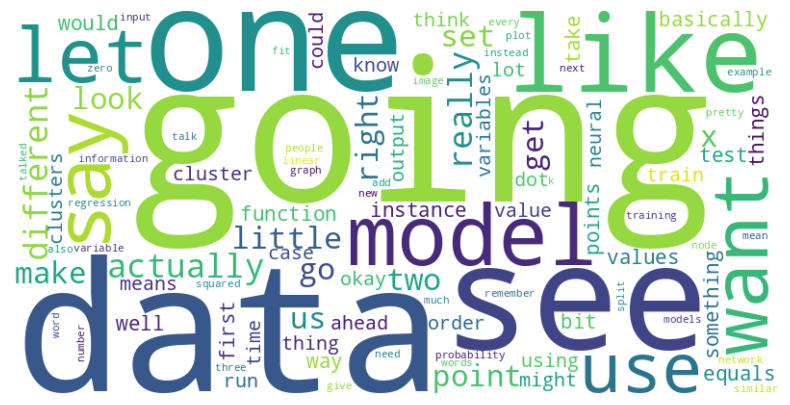

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_frequencies)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

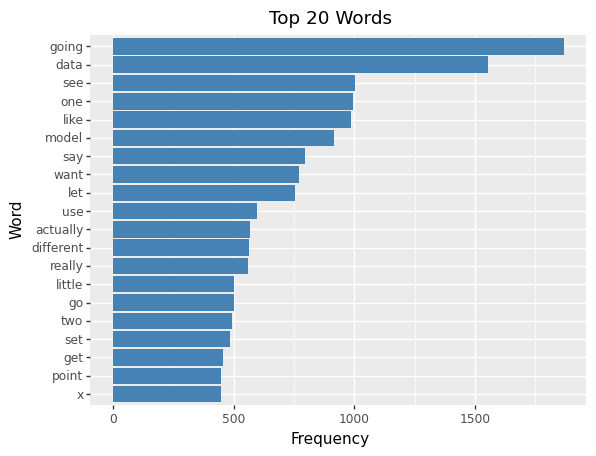

<ggplot: (755230913)>

In [9]:
from plotnine import *
import pandas as pd

# Convert the word frequencies into a DataFrame
df = pd.DataFrame(word_frequencies.most_common(20), columns=['word', 'frequency'])

# Sort the DataFrame in descending order of frequency
df = df.sort_values('frequency', ascending=True)

# Convert the 'word' column to a categorical with specified order
df['word'] = pd.Categorical(df['word'], categories=df['word'], ordered=True)

# Create the bar plot
(ggplot(df, aes(x='word', y='frequency')) +
        geom_bar(stat='identity', fill='steelblue') +
        coord_flip() +
        ggtitle('Top 20 Words') +
        xlab('Word') +  
        ylab('Frequency'))

### Data Cleaning and Preprocessing
The next step in our analysis was to clean and preprocess the data to make it suitable for our NLP models. Our Python script took several steps to clean the data:

Replacing '--' with a space ' '
Splitting text into tokens by white space
Removing punctuation from each token
Removing non-alphabetic tokens
Converting all tokens to lowercase
This process generated sequences of tokens, which were saved as 'overall_transcript_seq.txt'.

Subsequently, the script transformed the token sequences into a numerical representation using the Tokenizer function, which was fit to the lines of our document. This allowed us to encode the words into integers, a format suitable for our models.

Further processing involved separating our data into input and output elements and ensuring a uniform sequence length by padding the sequences. The processed data was then split into training and testing datasets, with 80% of the data allocated for training and the remaining 20% for testing.

The above steps ensured that our data was in an optimal format for feeding into our NLP models.

In [1]:
import string
import numpy as np
import tensorflow as tf
from random import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
# Loading and cleaning text
my_file = "transcripts/overall_transcript.txt"
seq_len = 100

# Load document
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# Turn document into clean tokens
def clean_doc(doc):
    doc = doc.replace('--', ' ')                         # replace '--' with a space ' '
    tokens = doc.split()                                 # split into tokens by white space
    table = str.maketrans('', '', string.punctuation)    # remove punctuation from each token
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()] # remove remaining tokens that are not alphabetic
    tokens = [word.lower() for word in tokens]           # make lower case
    return tokens

# Save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
 
doc = load_doc(my_file)
tokens = clean_doc(doc)
 
# Organize into sequences of tokens
length = seq_len + 1
sequences = list()
for i in range(length, len(tokens)):
    seq = tokens[i-length:i]    # select sequence of tokens
    line = ' '.join(seq)        # convert into a line
    sequences.append(line)      # store
 
# Save sequences to file
out_filename = my_file[:-4] + '_seq.txt'
save_doc(sequences, out_filename)

lines = doc.split('\n')

# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)


In [11]:
# Prepping Input and Output Data

# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# separate into input and output
sequences = pad_sequences(sequences)  # This line is added to pad the sequences to a uniform length
sequences = np.array(sequences)
sequences.shape

X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

# Train/Test Split
p_train = 0.8

n_train = int(X.shape[0]//(1/p_train))
X_train = X[0:n_train]
y_train = y[0:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

`sample_with_temperature(preds, temperature=0.5)`: This function changes how sure or unsure the model is when it guesses the next word. A low temperature makes the model very sure about its guess, but it might not be as creative. A high temperature makes the model less sure about its guess, which can make the guesses more diverse but potentially less accurate.

`generate_seq(model, tokenizer, seq_length, seed_text, n_words, temperature=1.0)`: This function generates new text using the trained model. It starts with some seed text and then generates a number of new words to follow that seed text. The temperature parameter controls how the model makes its guesses, as explained above.

The function works by converting the current text into numbers that the model can understand, then asking the model to guess the next word. The guessed word is added to the current text, and this process is repeated until the requested number of words has been generated. The generated text is then returned as a string.

In [12]:
# Functions to generate sequences
from random import randint
from pickle import load

# Sourced this code online to use temperature-based sampling
def sample_with_temperature(preds, temperature=0.5):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words, temperature=1.0):
    result = list()
    in_text = seed_text

    # generate a fixed number of words
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([in_text])[0]                    # encode the text as integer
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre') # truncate sequences to a fixed length
        preds = model.predict(encoded, verbose=0)[0]                            # predict probabilities for each word
        yhat = sample_with_temperature(preds, temperature)                      # apply temperature-based sampling

        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break

        # Append to input
        in_text += ' ' + out_word
        result.append(out_word)

    return ' '.join(result)

## Methods
For this project, we explored two models for generating text in the style of our professor’s online lectures: a locally-trained Long Short-Term Memory (LSTM) model and OpenAI's powerful GPT model, fine-tuned with our specific data.

### Model Selection
Our first choice was an LSTM model due to its accessibility and ability to be trained on a local machine. LSTM models are known for their effectiveness in sequence prediction tasks, such as text generation, because they can remember long-term dependencies. This makes them a popular choice for tasks involving human language.

In contrast, we utilized the GPT model for its advanced capabilities and the vast amount of data it was pre-trained on. To make it specific to our task, we fine-tuned it using our custom dataset.

### LSTM Architecture
Our LSTM model was designed as a deep network with two LSTM layers, each followed by dropout for regularization. The model has an embedding layer at the input, transforming integer-encoded words to dense vectors. The output layer is a dense layer with 'softmax' activation, used for predicting the probability distribution of the next word.

The model was compiled with the 'adam' optimizer and the 'categorical_crossentropy' loss, suitable for multi-class classification problems.

During the training process, the model's weights were saved whenever the validation loss improved, ensuring we kept the best model. The model was trained for 200 epochs with a batch size of 128.

In [ ]:
# Deep LSTM model
inputs = Input(shape=(seq_length,))
x = Embedding(vocab_size, 256, input_length=seq_length)(inputs)

x = LSTM(256, return_sequences=True)(x)  # return_sequences=True for stacking LSTM layers
x = Dropout(0.2)(x)

x = LSTM(256)(x)
x = Dropout(0.2)(x)

output = Dense(vocab_size, activation='softmax')(x)

lstm_model = Model(inputs=inputs, outputs=output)
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

{
    "tags": [
        "hide_output"
    ]
}

In [ ]:
# Training Deep LSTM Model
lstm_model.load_weights("models/deep_LSTM_model.h5")

# Save weights
checkpoint_filepath = "models/deep_LSTM_model.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Train Model
history_2 = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=128,
    callbacks=[checkpoint_callback]
)

{
    "tags": [
        "hide_output"
    ]
}

### GPT Fine-Tuning
To fine-tune the GPT model, we preprocessed our dataset differently. We cleaned the titles of the lectures and prepared a dataframe containing prompts and script text. The script text was tokenized and split into smaller chunks, each treated as a separate training example.

The fine-tuned model was then used to generate responses to prompts, providing a comparison to the LSTM model. We created two versions of the fine-tuned model - one using entire scripts truncated at 1500 words, and the other using 500 random samples of approximately 900 tokens from the lectures.

In [ ]:
# Loading and pre-processing data

import subprocess
import pandas as pd
import random

dfIN = pd.read_csv('VideoScriptsNoNoise.csv')

#Get rid of all unnecessary title words (only need the topic)
df = dfIN.drop('Script', axis = 1)
df['Title'] = df['Title'].str.replace('CPSC 392','')
df['Title'] = df['Title'].str.replace('CPSC 393','')
df['Title'] = df['Title'].str.replace('In','in')
df['Title'] = df['Title'].str.replace('intro','Intro')
df['Title'] = df['Title'].str.replace('Lecture','')
df['Title'] = df['Title'].str.replace('|','')
df['Title'] = df['Title'].str.replace('\d+','')
df['Title'] = df['Title'].str.replace('Part','')
df['Title'] = df['Title'].str.replace('Pt.','')
df['Title'] = df['Title'].str.replace('I','')
df['Title'] = df['Title'].str.replace('Neural Networks and Optimization V','Neural Networks and Optimization')

#Removes leading white space and newline characters
df['Title'] = df['Title'].str.strip()
df['ScriptNoNoise'] = df['ScriptNoNoise'].str.replace('\n', ' ')
df['ScriptNoNoise'] = df['ScriptNoNoise'].str.strip()

# Remove first bit of intro text since it will be reintroduced later after more processing
df['ScriptNoNoise'] = df['ScriptNoNoise'].str.split(n=10).str[10]

# Create the prompt to give gpt
df['Prompt'] = df['Title']

# Decided to remove Autoencoder lecture to test and compare generated lecture vs actual lecture
df = df.drop(44).reset_index()

#Creates a csv of only the data that gpt needs
prepared_data = df.loc[:,['Prompt','ScriptNoNoise']]

In [ ]:
# RANDOM SEED GENERATION MODEL V2

# Need around 500 examples
# prompt + completion can't exceed 2048 tokens
# Decided to grab 500 examples of about 900 tokens

#Create a new df based on random samples of 900 tokens from the 

prompts = []
completions = []
tokenSize = 300
indices = range(df['Title'].size)
numOfSamples = df['Title'].size
numOfGenerations = range(500)

for num in numOfGenerations:
    
    randint = random.randint(0, numOfSamples - 1)
    sample = prepared_data.iloc[randint]
    
    title = sample['Prompt']
    prompts.append(title)
    
    text = sample['ScriptNoNoise']
    textTokenized = text.split()
    textSize = len(textTokenized)
    
    start = 0
    end = tokenSize
    
    if textSize > tokenSize:
        start = random.randint(0, textSize - tokenSize + 1)
        end = start + tokenSize
    
    seed_text = ' '.join(textTokenized[start:end])
    seed_text = seed_text + 'END'
    completions.append('hello and welcome to your ' + title + ' lecture ' + seed_text)

prepared_data_seeded = pd.DataFrame({'prompt':prompts, 'completion':completions})
prepared_data_seeded.to_csv('prepared_dataSeeded300NoAE.csv',index=False)

In [ ]:
# USE THIS FOR SIMPLY CUTTING OFF LAST CHUNK OF LECTURE SO THAT GPT WILL ACCEPT IT MODEL V1

# Cut off at 1500 words
# Keep normal 50 lecture scripts

for row in range(prepared_data['ScriptNoNoise'].size):
    prepared_data['ScriptNoNoise'].iloc[row] = ' '.join(prepared_data['ScriptNoNoise'].iloc[row].split()[0:1500])
    
prepared_data['ScriptNoNoise'] = prepared_data['ScriptNoNoise'] + 'END'
prepared_data = prepared_data.rename(columns={"Prompt": "prompt", "ScriptNoNoise": "completion"})
prepared_data.to_csv('prepared_dataNoAE1500.csv',index=False)

#Reformats into a json file
subprocess.run('openai tools fine_tunes.prepare_data --file prepared_data.csv --quiet'.split())

In [ ]:
## Start fine-tuning
subprocess.run('openai api fine_tunes.create --training_file prepared_data_prepared.jsonl --model davinci --suffix "ChelseaLecturesV2"'.split())

# V1 IS GENERATED FROM SIMPLY CUTTING OFF ALL WORDS IN LECTURE PAST 1500 TOKENS
def generate_response_V1(prompt, temp, maxTokens):

    response = openai.Completion.create(
    model="davinci:ft-dylan:chelsealectures-2023-05-10-03-54-06", #ft-d4aLlShZHr81bjgHdsG9NCoH   ft-klhm:superhero-2023-02-01-14-56-48
    prompt=prompt,
    temperature=temp,
    max_tokens=maxTokens,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
    stop=["END"]
    )
    
    return response

# V1 IS GENERATED FROM GRABBING 500 RANDOM SEEDS OF TEXT FROM THE LECTURES THAT ARE 300 TOKENS LONG
# HAD A LOT MORE EXAMPLES TO GIVE TO GPT, BUT THE SEEDS COULD BE SNATCHED FROM THE MIDDLE OF A LECTURE AND NOT QUITE MAKE SENSE
# WITHOUT THE SURROUNDING CONTEXT
def generate_response_V1(prompt, temp, maxTokens):

    response = openai.Completion.create(
    model="davinci:ft-dylan:chelsealectures-2023-05-10-03-54-06", #ft-d4aLlShZHr81bjgHdsG9NCoH   ft-klhm:superhero-2023-02-01-14-56-48
    prompt=prompt,
    temperature=temp,
    max_tokens=maxTokens,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
    stop=["END"]
    )
    
    return response

In [ ]:
test = generate_response_V1('Autoencoders ->',0.7,256)

### Training
The LSTM model was trained locally for about 30 minutes. The GPT model was fine-tuned using OpenAI's API, which cost around $30.

### Evaluation Method
The evaluation of our models was qualitative, based on how coherent the generated text was and how well it responded to the provided prompts. We assessed whether the text made sense and maintained consistency with the lecture style.

## Results
Our experiments involved the use of both a Long Short-Term Memory (LSTM) model and a fine-tuned version of the GPT model for text generation. We also utilized an AI software from ElevenLabs.io to convert the generated text to an imitation of Chelsea's voice. The software required a minimum of 3 minutes of audio for training.

### LSTM Model
The LSTM model was trained on the transcript.txt, generating texts based on seed phrases extracted from the same source. The LSTM model, however, produced mostly incoherent sentences. Here are a few examples:

```
Seed text 1: set of variables we use matrix
Generated text 1: like we going to can gets look is the print of this i'm from this scores of we not the model i say clustering in the fit we make going from be as we we get noise is the same time ggplots of a positive and all i now a

Seed text 2: our data so one common way to prevent
Generated text 2: a k z point at the going of sites for to can going to say once so out goal now the columns the k subtracts as them is that we see it that the variables is the intercept the drawing are the new values we can say positives before pyramid

Seed text 3: time because it's super easy
Generated text 3: to the air two to all about so the few log use your tree and last with the add it we're that we using can expectation etc so is the roc as i'm say jumbled is for i not the data of of the number of of our many components
```

<audio controls>
  <source src="audio/LSTM Text.mp3" type="audio/mpeg">
  Your browser does not support the audio element.
</audio>

These results indicate that the LSTM model, while capable of producing text, struggled with creating coherent and contextually relevant sentences

### Fine-Tuned GPT Model

In contrast to the LSTM model, the GPT model that was fine-tuned on Chelsea's videos demonstrated a significantly improved performance. It was not only capable of generating coherent text but also mimicked Chelsea’s common speech patterns effectively. An example of this can be seen in the following generated text:

```
Corgis -> Pembroke Welsh Corgis are a very popular breed of dog and they're pretty adorable but there's a lot of myths out there about them that we want to talk about today so first off corgis are not from wales they're actually from england and the reason that we think that they're from wales is because when people started breeding them in the 1800s they were bred with welsh cattle dogs which is why people thought that they were welsh but really corgis are just a type of welsh cattle dog so if you ever meet someone who tells you that their corgi is a welsh dog tell them no it's not okay now let's talk about the myth that all corgis have those adorable little tails now this isn't true for every single corgi but it is true for most and what happens is when breeders are trying to get rid of certain traits in their dogs one way to do this is through selective breeding which means breeding animals together who have certain traits or lack certain traits in order to get rid of those traits or at least dilute them so one way selective breeding can be done with dogs is by docking their tails docking means cutting off part of the tail usually right at the end and this was done historically because people thought it would help prevent rabies or help keep ticks out but these days docking isn't really necessary anymore especially since we have vaccines for rabies and flea treatments for ticks however some breeders still choose to dock their puppies' tails even though it's technically illegal in many countries including the united states because there aren't any health benefits associated with having your tail docked it's considered cosmetic surgery which means you should ask your breeder if they've had their puppies' tails docked before buying one now another common myth about corgis has to do with how fast they can run well i'm here to tell you that while
```

<audio controls>
  <source src="audio/CorgiGenerated.mp3" type="audio/mpeg">
  Your browser does not support the audio element.
</audio>

These results strongly suggest that the GPT model, particularly when fine-tuned, is far superior to LSTM for this type of text generation task. This is due to GPT's more powerful architecture and ability to understand and generate contextually relevant and syntactically correct text.

## Reflection

It's clear that the landscape of text generation is complex and rapidly evolving. The difference in results between the LSTM and the GPT models was stark, revealing the advantages of advanced, transformer-based models like GPT for tasks that require a deep understanding of language structure and contextual relevance.

The LSTM model, while an excellent tool for sequence prediction problems, faced limitations in generating coherent and contextually accurate sentences. Despite being trained on a specific text, it struggled to create sentences that made logical sense or maintained a consistent topic. This could be due to LSTM's inherent limitations in handling long-term dependencies, and its lack of understanding of broader language structures and semantics.

On the other hand, the GPT model, demonstrated a clear superiority. It was able to maintain coherent narratives and accurately reflect the language patterns of the training data. Fine-tuning the GPT model on Dr. Parlett's videos took this a step further, allowing it to not just generate coherent text, but also mimic her speech patterns effectively. This illustrates the power of transfer learning, where a model trained on a vast corpus of data can be fine-tuned to specific styles or topics with smaller datasets.

The use of ElevenLabs.io's AI software for voice imitation was an interesting addition to the project. It successfully converted text to an imitation of Chelsea's voice, which could be a powerful tool for content creation in the future.

However, it's important to remember that AI-generated content should be used responsibly. The ability to mimic someone's speech patterns and voice brings with it ethical considerations about consent and misuse. The technology is impressive, but it's crucial to consider these factors when thinking about its applications.

Overall, this project was an enriching exploration of the capabilities of current AI technologies in the domain of text and speech generation. It shed light on the progress that has been made in the field and provided a glimpse into the potential of these technologies for the future.